## Benchmarking


I'm using this code to benchmark underlying function and my code generation tactics

will use a 2B1T + FWTD model and relise it at 20 m/s & 5 deg aoa

In [4]:
import sympy as sym
import sympy.physics.mechanics as me
import pandas as pd
import seaborn as sns

import numpy as np
from scipy.integrate import odeint,LSODA,BDF,solve_ivp
import matplotlib.pyplot as plt

import sys, os

sys.path.insert(1, os.path.join(sys.path[0], '../..'))
import custom_plot_objects as cpo

import ModelFramework as mf
import ModelFramework.Elements as ele
import ModelFramework.ExternalForces as ef

me.mechanics_printing()

### Define the Model

#### Create Parameter instance

In [5]:
half = sym.Rational(1,2)

# lets go for B2T2 (so 5 DoF)
p = mf.ModelParameters.DynamicModel(3+1)

## Create some global parameters
p.c = mf.ModelVariable(0.15,'c') # chord of wing

p.rho_t = mf.ModelVariable(2.75/1.345,'rho_t') # mass per unit length for the wing
p.s_t = mf.ModelVariable(1.345,'s_t') # chord of wing
p.ratio_fwt = mf.ModelVariable(0.345/1.345,'sigma') # chord of wing

# main Wing Structural Parameters
p.y_0 = sym.Symbol('y_0')
p.x_0 = sym.Symbol('x_0')

p.e_0 = mf.ModelVariable(0.25,'e_0')
p.x_f0 = mf.ModelVariable(0.5,'x_f0')
#p.x_f0 = sym.Rational(1,4)*p.c + p.e_0*p.c

p.s_0 = mf.ModelVariable(1,'s_0') # chord of wing
#p.s_0 = p.s_t*(1-p.ratio_fwt)# span

## force soome frequencies
#p.f_0 = fm.FwtVariable(2,'f_0') # first Bending mode frequency
#p.EI = (2*sym.pi*p.f_0/sym.Float(3.516))**2*p.rho_0*sym.Abs(p.c)*(p.s_0+p.s_1)**4
p.EI = mf.ModelVariable(59.375,'EI')

#p.f_1 = fm.FwtVariable(4,'f_1') # first Bending mode frequency
#p.I_0 = p.rho_t*p.c*(half*p.rho_t-p.x_f0)
#p.GJ = (sym.Rational(4,3)*p.f_1*(p.s_0+p.s_1))**2*p.I_0
p.GJ = mf.ModelVariable(855.625,'GJ')

## FWTD Structural Parameters
p.y_1 = sym.Symbol('y_1')
p.x_1 = sym.Symbol('x_1')

p.e_1 = mf.ModelVariable(0.25,'e_1')
p.x_f1 = sym.Rational(1,4)*p.c + p.e_1*p.c
p.Lambda = mf.ModelVariable(np.deg2rad(10),'Lambda')


p.s_1 = mf.ModelVariable(0.345,'s_1') # chord of wing
#p.s_1 = p.s_t * p.ratio_fwt # span

p.m_1 = mf.ModelVariable(0.3,'m_1')
p.I_xx_1 = sym.Rational(1,12)*p.m_1*p.s_1**2 # inertia of FWT (uniform bar)

## Aero Parameters
p.rho = mf.ModelVariable(1.225,'rho') # density
p.V = mf.ModelVariable(10,'V') # velocity
p.g  = mf.ModelVariable(9.81,'g') # gravity
p.alpha_r = mf.ModelVariable(np.deg2rad(3),'alpha_r') # root AoA
p.M_thetadot = mf.ModelVariable(1.2,'M_thetadot')


## Main Wing Specific
p.a_0 = mf.ModelVariable(2*np.pi,'a_0') # C_L of wing

## FWT Specific
p.a_1 = p.a_0 - p.a_0/p.s_1*p.y_1
p.alpha_1 = mf.ModelVariable(0,'alpha_1') # FWT alpha
p.alphadot_1 = mf.ModelVariable(0,'alphadot_1') # FWT alphadot

#### Create Transforms

In [54]:
#get shape functions for main wing
z_0,tau_0 = mf.ShapeFunctions_BN_TM(2,1,p.q[:-1],p.y_0,p.x_0,p.x_f0,0,factor=1)

#define wrefernce frames
wing_root_frame = mf.HomogenousTransform().R_y(p.alpha_r)
wing_aero_frame = wing_root_frame.Translate(p.x_0,p.y_0,z_0).subs({p.x_0:p.x_f0})
wing_tip_frame = wing_aero_frame.subs({p.y_0:p.s_0})
fwt_root_frame = wing_tip_frame.R_x(-p.q[-1])
fwt_com_frame = fwt_root_frame.Translate(0,p.s_1/2,0)

#Create Elemnts
M_wing = ele.MassMatrix(p.rho_t/p.c)
M_fwt = ele.MassMatrix(p.m_1,I_xx = p.I_xx_1)

inner_wing_ele = ele.FlexiElement(wing_root_frame,M_wing,p.x_0,p.y_0,z_0,p.c,p.s_0,p.x_f0,p.EI,p.GJ)
fwt_ele = ele.RigidElement(fwt_com_frame,M_fwt,True)


# Create Gravity forces
wing_GravityForces = ef.ContinuousGravityForce(p,wing_aero_frame,
                                                sym.Matrix([0,0,-p.g*p.rho_t/p.c]),(p.x_0,0,p.c),(p.y_0,0,p.s_0))

# Create AeroForces
wing_AeroForces = ef.AeroForce(p,wing_aero_frame,p.a_0,(p.y_0,0,p.s_0),
                               alphadot = tau_0.diff(me.dynamicsymbols._t),
                               M_thetadot = p.M_thetadot,
                               e = p.e_0,
                               rootAlpha = p.alpha_r,
                               deltaAlpha = tau_0,
                               alpha_zero = 0)


tau_s0 = tau_0.subs(p.y_0,p.s_0)
alpha_fwt = tau_s0 + p.alpha_1
alphadot_fwt = tau_s0.diff(me.dynamicsymbols._t) + p.alphadot_1

fwt_AeroForces = ef.AeroForce(p,fwt_root_frame.Translate(0,p.y_1,0),p.a_1,(p.y_1,0,p.s_1),
                               alphadot = alphadot_fwt,
                               M_thetadot = p.M_thetadot,
                               e = p.e_1,
                               rootAlpha = alpha_fwt,
                               deltaAlpha = 0,
                               alpha_zero = 0)

In [55]:
#Create Composite force
CompositeForce = ef.CompositeForce(p,[wing_AeroForces,fwt_AeroForces,wing_GravityForces])
# Create the SYmbolic Model
sm = mf.SymbolicModel.FromElementsAndForces(p,[inner_wing_ele,fwt_ele],CompositeForce)

# Setup Numeric Model Parameters


In [86]:
tmax, dt = 5, 0.01

#set velocity and alpha_r funcs
def Vfunc(t,x):
    return 20

def arfunc(t,x):
    return np.deg2rad(5)
    #return np.deg2rad(5)+np.sin(2*np.pi*1*t)*np.deg2rad(5)
    
## Get functions for Fwt AoA and its derivative
fwt_aoa = mf.GetAoA(p.alpha_r,0,p.Lambda.value,p.q[-1])
FwtAoA = sym.lambdify((p.alpha_r,p.x),fwt_aoa)
DotFwtAoA = sym.lambdify((p.alpha_r,p.x),fwt_aoa.diff(me.dynamicsymbols._t))

p.alpha_1.value = lambda t,x:FwtAoA(arfunc(t,x),x)
p.alphadot_1.value = lambda t,x:DotFwtAoA(arfunc(t,x),x)
p.V.value = Vfunc
p.alpha_r.value = arfunc

ts = np.arange(0, tmax+dt, dt)

constraints = [np.NaN]*p.qs*2

def objectiveDeriv(t,y):
    deriv = sm.deriv(t,y,p.GetNumericTuple(y,t))
    return tuple(np.where(np.isnan(constraints),deriv,constraints))

## Find the fixed point

In [87]:
from scipy.optimize import minimize
def obj(p0):
    v0=np.zeros_like(p0)
    y0 = [j for i in range(len(p0)) for j in [p0[i],v0[i]]]
    tup = p.GetNumericTuple(y0,0)
    res = sm.deriv(0,y0,tup)
    return sum((i**2 for i in res)) + res[-2]**2*10
y0 = [0]*p.qs*2
y0[-2] = 0
tup = p.GetNumericTuple(y0,0)
p0=[0]*p.qs
p0[-1] = 1.3
res = minimize(obj,p0)
p0 = res.x
v0=np.zeros_like(p0)
y0 = [j for i in range(len(p0)) for j in [p0[i],v0[i]]]
print(y0)

[0.013112318969030182, 0.0, -0.004453409319807138, 0.0, -0.00047751998741051553, 0.0, 0.12674347943115521, 0.0]


## create masses 

In [88]:
%prun -s tottime yData = solve_ivp(objectiveDeriv,(0,tmax),y0)

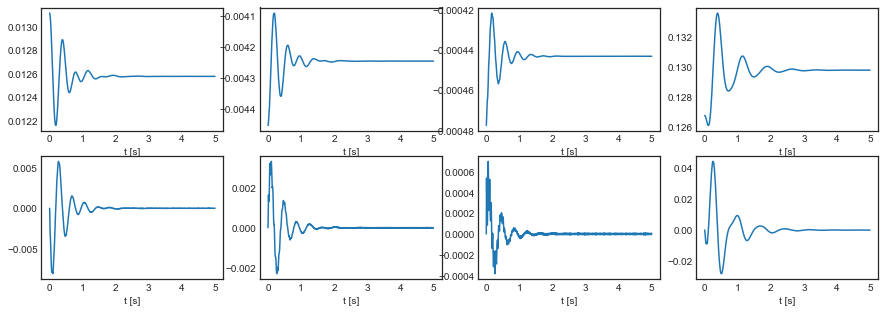

In [89]:
yi = yData.y
t = yData.t

plt.style.use('seaborn-white')

  
fig, axes = plt.subplots(2,int(len(yi)/2),figsize=(15,5))

for i in range(int(len(yi)/2)):
    # pos plot
    axes[0][i].plot(t,yi[i*2])
    axes[0][i].set_ylabel('')
    axes[0][i].set_xlabel('t [s]')
    
    # vel plot
    axes[1][i].plot(t,yi[i*2+1])
    axes[1][i].set_ylabel('')
    axes[1][i].set_xlabel('t [s]')